# Part 6: Convolutional Neural Networks in hls4ml

In this notebook you will learn how to train a pruned and quantized convolutional neural network (CNN) and deploy it using hls4ml. For this exercise, we will use the Street View House Numbers (SVHN) Dataset (http://ufldl.stanford.edu/housenumbers/).

The SVHN dataset consists of real-world images of house numbers extracted from Google Street View images. The format is similar to that of the MNIST dataset, but is a much more challenging real-world problem, as illustrated by the examples shown below.

All the images are in RGB format and have been cropped to 32x32 pixels. 
Unlike MNIST, more than one digit can be present in the same image and in these cases, the center digit is used to assign a label to the image.
Each image can belong to one of 10 classes, corresponding to digits 0 through 9.

![alt text](images/test.png "SVHN examples from the test dataset")

The SVHN dataset consists of 73,257 images for training (and 531,131 extra samples that are easier to classify and can be used as additional training data) and 26,032 images for testing.

# Model Baseline

In [1]:
pip list

Package                           Version
--------------------------------- -------------
absl-py                           1.4.0
accessible-pygments               0.0.4
aiohttp                           3.7.4.post0
alabaster                         0.7.13
alembic                           1.11.1
altair                            5.0.1
anyio                             3.6.2
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
asttokens                         2.2.1
astunparse                        1.6.3
async-generator                   1.10
async-lru                         2.0.2
async-timeout                     3.0.1
attrs                             21.4.0
Babel                             2.12.1
backcall                          0.2.0
backports.functools-lru-cache     1.6.4
beautifulsoup4                    4.12.2
bleach                            6.0.0
blinker                           1.6.2
bokeh                             3.1.1
boltons           

## Start with the neccessary imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
from tensorflow import keras

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2024-08-22 13:30:47.160325: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 13:30:47.190716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 13:30:47.190744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 13:30:47.191643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 13:30:47.196205: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 13:30:47.196636: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Input,BatchNormalization
from tensorflow.keras.layers import Activation,AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt

import glob
import os
#Packages for Quantization and Pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
import tensorflow.compat.v2 as tf
from tensorflow_model_optimization.sparsity import keras as sparsity
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm,QConv2D,InputLayer,QBatchNormalization
from qkeras.autoqkeras.utils import print_qmodel_summary
import hls4ml
from hls4ml.converters import convert_from_keras_model
import plotting

/opt/conda/lib/python3.10/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [4]:
#pip install --force-reinstall protobuf==3.20.2

ame: protobuf
Version: 4.24.0
Summary: 
Home-page: https://developers.google.com/protocol-buffers/
Author: protobuf@googlegroups.com
Author-email: protobuf@googlegroups.com
License: 3-Clause BSD License
Location: /opt/conda/lib/python3.10/site-packages
Requires: 
Required-by: googleapis-common-protos, onnx, tensorboard, tensorflow, tensorflow-datasets, tensorflow-metadata
Note: you may need to restart the kernel to use updated packages.

## Fetch the SVHN dataset using Tensorflow Dataset

In this part we will fetch the trainining, validation and test dataset using Tensorflow Datasets (https://www.tensorflow.org/datasets). We will not use the 'extra' training in order to save time, but you could fetch it by adding `split='train[:90%]+extra'`. We will use the first 90% of the training data for training and the last 10% for validation.

We'll use TensorFlow Dataset to prepare our datasets. We'll fetch the training dataset as tuples, and the test dataset as numpy arrays

In [2]:
# Treino Ambiente
noevent_train = np.load('data/noevent_train.npy')
print('Treino No Event:', np.shape(noevent_train))

# Teste Ambiente
noevent_test = np.load('data/noevent_test.npy')
print('Teste No Event:', np.shape(noevent_test))

# Treino Corrida
running_train=np.load('data/running_train.npy')
print('Treino Running:', np.shape(running_train))

# Teste Corrida
running_test=np.load('data/running_test.npy')
print('Teste Running:', np.shape(running_test))

# Treino Martelete
stonecrusher_train = np.load('data/stonecrusher_train.npy')
print('Treino Stone Crusher:', np.shape(stonecrusher_train))

# Teste Martelete
stonecrusher_test = np.load('data/stonecrusher_test.npy')
print('Teste Stone Crusher:', np.shape(stonecrusher_test))

# Treino Picareta
pickaxe_train = np.load('data/pickaxe_train.npy')
print('Treino Pickaxe:', np.shape(pickaxe_train))

# Teste Picareta
pickaxe_test = np.load('data/pickaxe_test.npy')
print('Teste Pickaxe:', np.shape(pickaxe_test))

Treino No Event: (10688, 64, 32)
Teste No Event: (1280, 64, 32)
Treino Running: (689, 64, 32)
Teste Running: (94, 64, 32)
Treino Stone Crusher: (544, 64, 32)
Teste Stone Crusher: (77, 64, 32)
Treino Pickaxe: (770, 64, 32)
Teste Pickaxe: (90, 64, 32)


In [6]:
x_andre=np.load('x_andre.npy')

In [3]:
# Definitions about dataset
n_classes=4   #number of classes
n_rows=64     #number of rows in each image
n_cols=32     #number of columns in each image

# Add the fourth dimension that corresponds to channel
noevent_train=noevent_train.reshape(-1,n_rows,n_cols,1)
running_train=running_train.reshape(-1,n_rows,n_cols,1)
stonecrusher_train=stonecrusher_train.reshape(-1,n_rows,n_cols,1)
pickaxe_train=pickaxe_train.reshape(-1,n_rows,n_cols,1)

noevent_test=noevent_test.reshape(-1,n_rows,n_cols,1)
running_test=running_test.reshape(-1,n_rows,n_cols,1)
stonecrusher_test=stonecrusher_test.reshape(-1,n_rows,n_cols,1)
pickaxe_test=pickaxe_test.reshape(-1,n_rows,n_cols,1)

# Assign a number for each train class
y_noevent_train=np.zeros(np.shape(noevent_train)[0])
y_running_train=np.ones(np.shape(running_train)[0])
y_stonecrusher_train=2*np.ones(np.shape(stonecrusher_train)[0])
y_pickaxe_train=3*np.ones(np.shape(pickaxe_train)[0])

# Assign a number for each test class
y_noevent_test=np.zeros(np.shape(noevent_test)[0])
y_running_test=np.ones(np.shape(running_test)[0])
y_stonecrusher_test=2*np.ones(np.shape(stonecrusher_test)[0])
y_pickaxe_test=3*np.ones(np.shape(pickaxe_test)[0])

# Concatenate all data and split in train and validation subset
x_train=np.concatenate([noevent_train,running_train,stonecrusher_train,pickaxe_train])
y_train=np.concatenate([y_noevent_train,y_running_train,y_stonecrusher_train,y_pickaxe_train])
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

# Concatenate all test data
x_test=np.concatenate([noevent_test,running_test,stonecrusher_test,pickaxe_test])
y_test=np.concatenate([y_noevent_test,y_running_test,y_stonecrusher_test,y_pickaxe_test])

#Convert the class vector to categorical
y_cat_train=to_categorical(y_train)
y_cat_val=to_categorical(y_val)
y_cat_test=to_categorical(y_test)

# Verify the subsets
print(np.shape(x_train))
print(np.shape(y_cat_train))
print(np.shape(x_val))
print(np.shape(y_cat_val))
print(np.shape(x_test))
print(np.shape(y_cat_test))

(8883, 64, 32, 1)
(8883, 4)
(3808, 64, 32, 1)
(3808, 4)
(1541, 64, 32, 1)
(1541, 4)


In [4]:
np.shape(noevent_train)

(10688, 64, 32, 1)

In [7]:
x_nada_andre_4_amostras =noevent_train[:4]
y_nada_andre_4_amostras =y_noevent_train[:4]
np.save('Amostras/x_nada_andre_4_amostras.npy',x_nada_andre_4_amostras)
np.save('Amostras/y_nada_andre_4_amostras.npy',y_nada_andre_4_amostras)


x_corrida_andre_4_amostras =running_train[:4]
y_corrida_andre_4_amostras =y_running_train[:4]
np.save('Amostras/x_corrida_andre_4_amostras.npy',x_corrida_andre_4_amostras)
np.save('Amostras/y_corrida_andre_4_amostras.npy',y_corrida_andre_4_amostras)


x_martelete_andre_4_amostras =stonecrusher_train[:4]
y_martelete_andre_4_amostras =y_stonecrusher_train[:4]
np.save('Amostras/x_martelete_andre_4_amostras.npy',x_martelete_andre_4_amostras)
np.save('Amostras/y_martelete_andre_4_amostras.npy',y_martelete_andre_4_amostras)

x_picareta_andre_4_amostras =pickaxe_train[:4]
y_picareta_andre_4_amostras =y_pickaxe_train[:4]
np.save('Amostras/x_picareta_andre_4_amostras.npy',x_picareta_andre_4_amostras)
np.save('Amostras/y_picareta_andre_4_amostras.npy',y_picareta_andre_4_amostras)




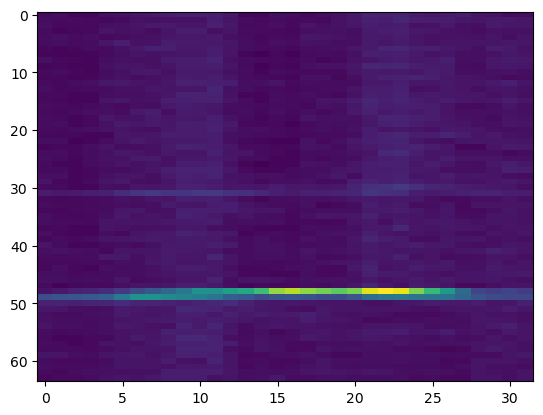

In [11]:
plt.imshow(x_picareta_andre_4_amostras[0],aspect='auto')

In [8]:
# plt.imshow(running_test[60,:,:,0],aspect='auto')

## Defining the model

We then need to define a model. For the lowest possible latency, each layer should have a maximum number of trainable parameters of 4096. This is due to fixed limits in the Vivado compiler, beyond which maximally unrolled (=parallel) compilation will fail. This will allow us to use `strategy = 'latency'` in the hls4ml part, rather than `strategy = 'resource'`, in turn resulting in lower latency

In [9]:
#Modelo definido com sequencial

from tensorflow.keras.models import Sequential
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.regularizers import l1
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l2
from keras.models import load_model
from tensorflow.keras.models import Model

weight_decay=1.e-3
filters=[16,32,64]                     #number of filter in each convolutional layer
neurons=[30,30]                        #number of filter in each dense layer
BN=True                                #if true apply batch normalization
pool_size=[(2,1),[2,2],[2,2]]          #pool_size for MaxPooling2D layer
#pool_size=(2,2)
drop_prob=0.2                          #dropout probability
x_in=x=Input(shape=(n_rows,n_cols,1))


model_baseline_sequencial = Sequential([
  Conv2D(filters=filters[0],kernel_size=[3,3],strides=[1,1],kernel_initializer="he_normal",use_bias=False,
         kernel_regularizer=l2(weight_decay),activation='relu', input_shape=(64, 32, 1)),
  BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay)),
  AveragePooling2D(pool_size=pool_size[0]),

  Conv2D(filters=filters[1],kernel_size=[3,3],strides=[1,1],kernel_initializer="he_normal",use_bias=False,
         kernel_regularizer=l2(weight_decay),activation='relu'),
  BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay)),
  AveragePooling2D(pool_size=pool_size[1]),

  Conv2D(filters=filters[1],kernel_size=[3,3],strides=[1,1],kernel_initializer="he_normal",use_bias=False,
         kernel_regularizer=l2(weight_decay), activation='relu'),
  BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay)),
  AveragePooling2D(pool_size=pool_size[1]),

  Flatten(),

  Dense(units=neurons[0],kernel_regularizer=l2(weight_decay),use_bias=False,activation='relu'),
  BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay)),

  Dense(units=neurons[0],kernel_regularizer=l2(weight_decay),use_bias=False,activation='relu'),
  BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay)),

  Dense(units=n_classes),
  Activation('softmax')

])



2024-08-19 11:58:24.959638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
'''
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model

weight_decay=1.e-3
filters=[16,32,64]                     #number of filter in each convolutional layer
neurons=[30,30]                        #number of filter in each dense layer
BN=True                                #if true apply batch normalization
pool_size=[(2,1),[2,2],[2,2]]          #pool_size for MaxPooling2D layer
#pool_size=(2,2)
drop_prob=0.2                          #dropout probability
x_in=x=Input(shape=(n_rows,n_cols,1))


x1=Conv2D(filters=filters[0],kernel_size=(3,3),strides=[1,1],kernel_initializer="he_normal",use_bias=False,
         kernel_regularizer=l2(weight_decay))(x)
x2 = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x1)
x3=Activation('relu')(x2)
x4=AveragePooling2D(pool_size=pool_size[0])(x3)

x5=Conv2D(filters=filters[1],kernel_size=(3,3),strides=[1,1],kernel_initializer="he_normal",use_bias=False,
         kernel_regularizer=l2(weight_decay))(x4)
x6 = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x5)
x7=Activation('relu')(x6)
x8=AveragePooling2D(pool_size=pool_size[1])(x7)

x9=Conv2D(filters=filters[2],kernel_size=(3,3),strides=[1,1],kernel_initializer="he_normal",use_bias=False,
         kernel_regularizer=l2(weight_decay))(x8)
x10 = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay),)(x9)
x11=Activation('relu')(x10)
x12=AveragePooling2D(pool_size=pool_size[2])(x11)
        
x13 = Flatten()(x12)

x14=Dense(neurons[0],kernel_regularizer=l2(weight_decay),use_bias=False)(x13)
x15 = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x14)
x16=Activation('relu')(x15)

x17=Dense(neurons[1],kernel_regularizer=l2(weight_decay),use_bias=False)(x16)
x18 = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x17)
x19=Activation('relu')(x18)

x20=Dense(int(n_classes))(x19)
x_out_act=Activation('softmax')(x20)



model_baseline=Model(inputs=[x_in],outputs=[x_out_act],name='keras_baseline')
'''

'\nfrom tensorflow.keras.layers import Input\nfrom tensorflow.keras.layers import BatchNormalization\nfrom tensorflow.keras.layers import Conv2D\nfrom tensorflow.keras.regularizers import l1\nfrom tensorflow.keras.layers import MaxPooling2D, AveragePooling2D\nfrom tensorflow.keras.layers import Activation\nfrom tensorflow.keras.layers import Flatten\nfrom tensorflow.keras.layers import Dense\nfrom tensorflow.keras.regularizers import l2\nfrom tensorflow.keras.models import load_model\n\nfrom tensorflow.keras.models import Model\n\nweight_decay=1.e-3\nfilters=[16,32,64]                     #number of filter in each convolutional layer\nneurons=[30,30]                        #number of filter in each dense layer\nBN=True                                #if true apply batch normalization\npool_size=[(2,1),[2,2],[2,2]]          #pool_size for MaxPooling2D layer\n#pool_size=(2,2)\ndrop_prob=0.2                          #dropout probability\nx_in=x=Input(shape=(n_rows,n_cols,1))\n\n\nx1=Conv2

In [11]:
#model_baseline.summary()

Lets check if this model can be implemented completely unrolled (=parallel)

## Callbacks

In [12]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
filepath_baseline="best_baseline_Andre_sequencial.h5"

patience     =30     #number of epochs with no improvement after which tranning will stop
lr_factor    =0.1    #factor by which the learning rate will be reduced. new_lr = lr * factor
lr_patience  =5     #number of epochs with no improvement after which learning rate will be reduced.
lr_min_delta =0.0001 #threshold for measuring the new optimum, to only focus on significant changes (min_delta).
lr_cooldown  =4     #number of epochs to wait before resuming normal operation after lr has been reduced.
lr_minimum   =0     #lower bound on the learning rate.

early_stop=EarlyStopping(monitor='val_accuracy',patience=patience,verbose=1,restore_best_weights=True) #early stopping

#Save the best model
checkpoint = ModelCheckpoint(filepath_baseline,save_weights_only=False, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

#Reduce the learning rate when the results are not improving
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=lr_factor, patience=lr_patience,
                                mode='auto', verbose=1, min_delta=lr_min_delta,
                                 cooldown=lr_cooldown, min_lr=lr_minimum)

callbacks_list_baseline=[early_stop,checkpoint,reduce_lr]


## Training

In [13]:
validation_split = 0.20 # proportion of the trainning data that will be used for validation
batch_size=32           #batch size
lr=0.0001               #learning_rate
epochs=100
#number of epochs

train_baseline_sequencial = False
if train_baseline_sequencial==True:
    opt = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    model_baseline_sequencial.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model_baseline_sequencial.fit(x=x_train,y=y_cat_train,batch_size=batch_size ,epochs=epochs,
              validation_data=[x_val,y_cat_val],callbacks=callbacks_list_baseline)
else:
    model_baseline_sequencial=load_model(filepath_baseline)

In [14]:
'''
validation_split = 0.20 # proportion of the trainning data that will be used for validation
batch_size=32           #batch size
lr=0.0001               #learning_rate
epochs=100
#number of epochs

train_baseline = False
if train_baseline==True:
    opt = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    model_baseline.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model_baseline.fit(x=x_train,y=y_cat_train,batch_size=batch_size ,epochs=epochs,
              validation_data=[x_val,y_cat_val],callbacks=callbacks_list_baseline)
else:
    model_baseline=load_model(filepath_baseline)
'''

"\nvalidation_split = 0.20 # proportion of the trainning data that will be used for validation\nbatch_size=32           #batch size\nlr=0.0001               #learning_rate\nepochs=100\n#number of epochs\n\ntrain_baseline = False\nif train_baseline==True:\n    opt = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)\n    model_baseline.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])\n    history = model_baseline.fit(x=x_train,y=y_cat_train,batch_size=batch_size ,epochs=epochs,\n              validation_data=[x_val,y_cat_val],callbacks=callbacks_list_baseline)\nelse:\n    model_baseline=load_model(filepath_baseline)\n"

In [15]:
#Modelo no formato sequencial

In [16]:
model_baseline_sequencial.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 30, 16)        144       
                                                                 
 batch_normalization (BatchN  (None, 62, 30, 16)       64        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 31, 30, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 28, 32)        4608      
                                                                 
 batch_normalization_1 (Batc  (None, 29, 28, 32)       128       
 hNormalization)                                                 
                                                        

## Testing

In [17]:
from sklearn.metrics import confusion_matrix
model_baseline_sequencial.evaluate(x_train,y_cat_train)
y_pred_cat=model_baseline_sequencial.predict(x_train)
y_pred=np.argmax(y_pred_cat,axis=1)
cm=confusion_matrix(y_train,y_pred)
cm

278/278 [==============================] - 1s 5ms/step


array([[7438,    0,    0,    0],
       [   4,  480,    7,    1],
       [   0,    2,  399,    0],
       [   7,    0,    0,  545]])

In [18]:
model_baseline_sequencial.evaluate(x_val,y_cat_val)
y_pred_val_cat=model_baseline_sequencial.predict(x_val)
y_pred_val=np.argmax(y_pred_val_cat,axis=1)
cm_val=confusion_matrix(np.argmax(y_cat_val, axis=1),y_pred_val) # create confusion matrix
cm_val

119/119 [==============================] - 1s 5ms/step


array([[3249,    0,    0,    1],
       [   8,  176,    5,    8],
       [   1,    0,  142,    0],
       [   2,    2,    0,  214]])

In [19]:
model_baseline_sequencial.evaluate(x_test,y_cat_test)
y_pred_test_cat=model_baseline_sequencial.predict(x_test)
y_pred_test=np.argmax(y_pred_test_cat,axis=1)
cm_test=confusion_matrix(np.argmax(y_cat_test, axis=1),y_pred_test)
cm_test

49/49 [==============================] - 0s 5ms/step


array([[1280,    0,    0,    0],
       [   6,   86,    1,    1],
       [   1,    1,   75,    0],
       [   0,    0,    0,   90]])

25/25 [==============================] - 0s 5ms/step
10688 689 544 770


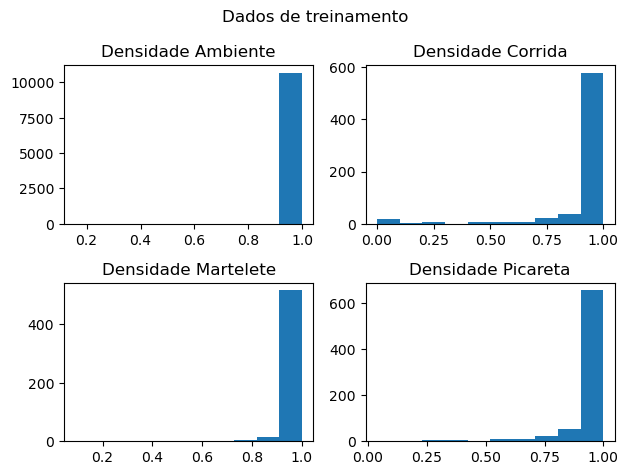

In [20]:
# Histograma da distribuição das probabilidades por classe
ambiente = model_baseline_sequencial.predict(noevent_train)
ambiente_prob = []

for i in range(len(ambiente)):
    ambiente_prob.append(ambiente[i][0])

corrida = model_baseline_sequencial.predict(running_train)
corrida_prob = []

for i in range(len(corrida)):
    corrida_prob.append(corrida[i][1])

martelete = model_baseline_sequencial.predict(stonecrusher_train)
martelete_prob = []

for i in range(len(martelete)):
    martelete_prob.append(martelete[i][2])

picareta = model_baseline_sequencial.predict(pickaxe_train)
picareta_prob = []

for i in range(len(picareta)):
    picareta_prob.append(picareta[i][3])

print(len(ambiente_prob), len(corrida_prob), len(martelete_prob), len(picareta_prob))

fig, axs = plt.subplots(2, 2, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0][0].hist(ambiente_prob)
axs[0][0].set_title('Densidade Ambiente')
axs[0][1].hist(corrida_prob)
axs[0][1].set_title('Densidade Corrida')
axs[1][0].hist(martelete_prob)
axs[1][0].set_title('Densidade Martelete')
axs[1][1].hist(picareta_prob)
axs[1][1].set_title('Densidade Picareta')
fig.suptitle('Dados de treinamento')

plt.show()

3/3 [==============================] - 0s 5ms/step
1280 94 77 90


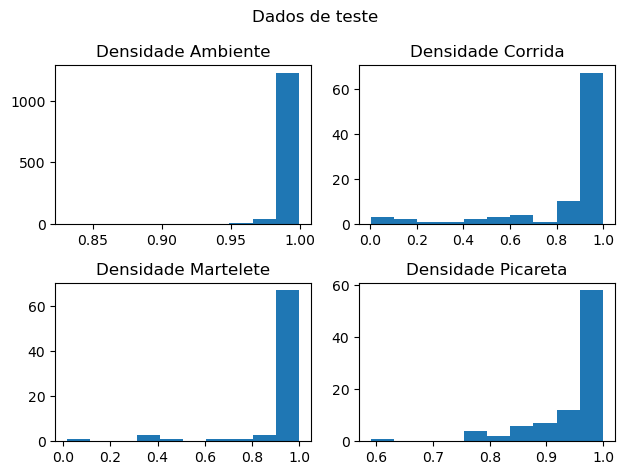

In [21]:
# Histograma da distribuição das probabilidades por classe
ambiente = model_baseline_sequencial.predict(noevent_test)
ambiente_prob = []

for i in range(len(ambiente)):
    ambiente_prob.append(ambiente[i][0])

corrida = model_baseline_sequencial.predict(running_test)
corrida_prob = []

for i in range(len(corrida)):
    corrida_prob.append(corrida[i][1])

martelete = model_baseline_sequencial.predict(stonecrusher_test)
martelete_prob = []

for i in range(len(martelete)):
    martelete_prob.append(martelete[i][2])

picareta = model_baseline_sequencial.predict(pickaxe_test)
picareta_prob = []

for i in range(len(picareta)):
    picareta_prob.append(picareta[i][3])

print(len(ambiente_prob), len(corrida_prob), len(martelete_prob), len(picareta_prob))

fig, axs = plt.subplots(2, 2, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0][0].hist(ambiente_prob)
axs[0][0].set_title('Densidade Ambiente')
axs[0][1].hist(corrida_prob)
axs[0][1].set_title('Densidade Corrida')
axs[1][0].hist(martelete_prob)
axs[1][0].set_title('Densidade Martelete')
axs[1][1].hist(picareta_prob)
axs[1][1].set_title('Densidade Picareta')
fig.suptitle('Dados de teste')

plt.show()

In [22]:
#Criar modelo com outputs de todas as camadas
#Compilar modelo


extractor_baseline = keras.Model(inputs=model_baseline_sequencial.inputs,
                        outputs=[layer.output for layer in model_baseline_sequencial.layers])
opt = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
extractor_baseline.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [23]:
#extractor.predict(x_andre)

In [24]:
'''
import pickle
with open("resposta_modelo_baseline", "wb") as fp:   #Pickling
    pickle.dump(teste, fp)
with open("test", "rb") as fp:   # Unpickling
   b = pickle.load(fp)
'''

'\nimport pickle\nwith open("resposta_modelo_baseline", "wb") as fp:   #Pickling\n    pickle.dump(teste, fp)\nwith open("test", "rb") as fp:   # Unpickling\n   b = pickle.load(fp)\n'

# Quantization

## Defining the model

In [25]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm,QConv2D


weight_decay=1.e-3
filters=[16,32,64]                     #number of filter in each convolutional layer
neurons=[30,30]                        #number of filter in each dense layer
BN=True                                #if true apply batch normalization
pool_size=[(2,1),[2,2],[2,2]]          #pool_size for MaxPooling2D layer
#pool_size=(2,2)
drop_prob=0.2                          #dropout probability
x_in=x=Input(shape=(n_rows,n_cols,1))


qmodel_sequencial = Sequential([
  InputLayer(input_shape=(64, 32, 1)),
  QConv2DBatchnorm(filters=filters[0], kernel_size=(3,3), strides=[1,1],
                         kernel_quantizer="quantized_bits(16,6,alpha=1)", 
                         bias_quantizer="quantized_bits(16,6,alpha=1)",
                         kernel_initializer='lecun_uniform', kernel_regularizer=l2(weight_decay),use_bias=True),
  QActivation('quantized_relu(8)'),
  MaxPooling2D(pool_size=pool_size[0]),

   QConv2DBatchnorm(filters=filters[1], kernel_size=(3,3), strides=[1,1],
                         kernel_quantizer="quantized_bits(10,2,alpha=1)", 
                         bias_quantizer="quantized_bits(10,2,alpha=1)",
                         kernel_initializer='lecun_uniform', kernel_regularizer=l2(weight_decay), use_bias=True),
  QActivation('quantized_relu(8)'),
  MaxPooling2D(pool_size=pool_size[1]),

  QConv2DBatchnorm(filters=filters[2], kernel_size=(3,3), strides=[1,1],
                         kernel_quantizer="quantized_bits(10,2,alpha=1)", 
                         bias_quantizer="quantized_bits(10,2,alpha=1)",
                         kernel_initializer='lecun_uniform', kernel_regularizer=l2(weight_decay),use_bias=True),
  QActivation('quantized_relu(8)'),
  MaxPooling2D(pool_size=pool_size[2]),
  
  Flatten(),

  QDense(units=neurons[0],kernel_quantizer="quantized_bits(8,0,alpha=1)",
            kernel_initializer="he_normal", kernel_regularizer=l2(weight_decay), use_bias=False),
  QBatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay)),
  QActivation('quantized_relu(8)'),

    
  QDense(units=neurons[1],kernel_quantizer="quantized_bits(8,0,alpha=1)",
            kernel_initializer="he_normal", kernel_regularizer=l2(weight_decay), use_bias=False),
  QBatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay)),
  QActivation('quantized_relu(8)'),

    
  Dense(units=n_classes),
  Activation('softmax')

])



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
qmodel_sequencial.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_conv2d_batchnorm (QConv2D  (None, 62, 30, 16)       225       
 Batchnorm)                                                      
                                                                 
 q_activation (QActivation)  (None, 62, 30, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 30, 16)       0         
 )                                                               
                                                                 
 q_conv2d_batchnorm_1 (QConv  (None, 29, 28, 32)       4769      
 2DBatchnorm)                                                    
                                                                 
 q_activation_1 (QActivation  (None, 29, 28, 32)       0         
 )                                                    

In [27]:
from qkeras.autoqkeras.utils import print_qmodel_summary
print_qmodel_summary(qmodel_sequencial)   

q_conv2d_batchnorm   f=16 quantized_bits(16,6,0,alpha=1) quantized_bits(16,6,0,alpha=1) 
q_activation         quantized_relu(8)
q_conv2d_batchnorm_1 f=32 quantized_bits(10,2,0,alpha=1) quantized_bits(10,2,0,alpha=1) 
q_activation_1       quantized_relu(8)
q_conv2d_batchnorm_2 f=64 quantized_bits(10,2,0,alpha=1) quantized_bits(10,2,0,alpha=1) 
q_activation_2       quantized_relu(8)
q_dense              u=30 quantized_bits(8,0,0,alpha=1) 
q_batch_normalization QBN, mean=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
q_activation_3       quantized_relu(8)
q_dense_1            u=30 quantized_bits(8,0,0,alpha=1) 
q_batch_normalization_1 QBN, mean=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
q_activation_4       quantized_relu(8)



## Callback

In [28]:
filepath_quantized="best_quantized__sequencial_Andre.h5" #path to save the best model_baseline

patience     =30     #number of epochs with no improvement after which tranning will stop
lr_factor    =0.1    #factor by which the learning rate will be reduced. new_lr = lr * factor
lr_patience  =5     #number of epochs with no improvement after which learning rate will be reduced.
lr_min_delta =0.0001 #threshold for measuring the new optimum, to only focus on significant changes (min_delta).
lr_cooldown  =4     #number of epochs to wait before resuming normal operation after lr has been reduced.
lr_minimum   =0     #lower bound on the learning rate.

early_stop=EarlyStopping(monitor='val_accuracy',patience=patience,verbose=1,restore_best_weights=True) #early stopping

#Save the best model
checkpoint = ModelCheckpoint(filepath_quantized,save_weights_only=False, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max',)

#Reduce the learning rate when the results are not improving
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=lr_factor, patience=lr_patience,
                                mode='auto', verbose=1, min_delta=lr_min_delta,
                                 cooldown=lr_cooldown, min_lr=lr_minimum)

callbacks_list_quantized=[early_stop,checkpoint]#,reduce_lr]


## Training

In [29]:
train_quantized_sequencial= False

if train_quantized_sequencial==True:
    validation_split = 0.20  # proportion of the trainning data that will be used for validation
    batch_size=32            #batch size
    lr=1e-3                  #learning_rate
    epochs=500               #number of epochs

    opt = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel_sequencial.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    qmodel_sequencial.fit(x=x_train,y=y_cat_train,batch_size=batch_size ,epochs=epochs,
              validation_split=validation_split,callbacks=callbacks_list_quantized)
else:
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    qmodel_sequencial = tf.keras.models.load_model(filepath_quantized, custom_objects=co)

## Testing

In [30]:
qmodel_sequencial.evaluate(x_train,y_cat_train)
y_pred_cat=qmodel_sequencial.predict(x_train)
y_pred=np.argmax(y_pred_cat,axis=1)
cm=confusion_matrix(y_train,y_pred)
cm


278/278 [==============================] - 6s 21ms/step


array([[7438,    0,    0,    0],
       [  18,  473,    0,    1],
       [   0,    0,  399,    2],
       [  11,    0,    0,  541]])

In [31]:
qmodel_sequencial.evaluate(x_val,y_cat_val)
y_pred_val_cat=qmodel_sequencial.predict(x_val)
y_pred_val=np.argmax(y_pred_val_cat,axis=1)
cm_val=confusion_matrix(np.argmax(y_cat_val, axis=1),y_pred_val) # create confusion matrix
cm_val

119/119 [==============================] - 2s 21ms/step


array([[3248,    1,    0,    1],
       [  20,  175,    0,    2],
       [   2,    0,  137,    4],
       [   8,    0,    0,  210]])

In [32]:
qmodel_sequencial.evaluate(x_test,y_cat_test)
y_pred_test_cat=qmodel_sequencial.predict(x_test)
y_pred_test=np.argmax(y_pred_test_cat,axis=1)
cm_test=confusion_matrix(np.argmax(y_cat_test, axis=1),y_pred_test)
cm_test

49/49 [==============================] - 1s 22ms/step


array([[1280,    0,    0,    0],
       [  13,   80,    0,    1],
       [   3,    0,   73,    1],
       [   3,    0,    0,   87]])

In [33]:
extractor_quantized = keras.Model(inputs=qmodel_sequencial.inputs,
                     outputs=[layer.output for layer in qmodel_sequencial.layers])

'''
import pickle
with open("resposta__modelo_quantized", "wb") as fp:   #Pickling
    pickle.dump(resposta_quantized, fp)
'''

'\nimport pickle\nwith open("resposta__modelo_quantized", "wb") as fp:   #Pickling\n    pickle.dump(resposta_quantized, fp)\n'

# Pruning

In [63]:
# for layer in qmodel.layers: print(layer.get_config(), layer.get_weights())

Looks good! It's below the Vivado-enforced unroll limit of 4096.

## Prune dense and convolutional layers
Since we've seen in the previous notebooks that pruning can be done at no accuracy cost, let's prune the convolutional and dense layers to 50% sparsity, skipping the output layer

In [34]:
validation_split = 0.3
NSTEPS = int(np.shape(x_train)[0]*(1-validation_split))  // batch_size #calculate the number of steps pr epoch
print('Number of training steps per epoch is {}'.format(NSTEPS))
initial_complete_sparsity=0
final_complete_sparsity=0.10
final_epoch=10


pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = initial_complete_sparsity,
                                                                   final_sparsity = final_complete_sparsity,
                                                                   begin_step = NSTEPS*2,
                                                                   end_step = NSTEPS*final_epoch,
                                                                   frequency = NSTEPS)}
def prune_complete_Function(layer):
    '''
    Function that creates a prunning schedule
    '''
    
    pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = initial_complete_sparsity,
                                                                   final_sparsity = final_complete_sparsity,
                                                                   begin_step = NSTEPS*2,
                                                                   end_step = NSTEPS*final_epoch,
                                                                   frequency = NSTEPS)
                     }
    if isinstance(layer, tf.keras.layers.Conv2D):
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='output_dense':
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer


Number of training steps per epoch is 194


# Training Pruned Baseline

In [35]:
def plot_evaluate_epochs(history, file_name=None):
    fig, axs = plt.subplots(2, 1, figsize=(8,10))
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set(ylabel='Accuracy')
    axs[0].legend(['train', 'val'], loc='lower right')
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(ylabel='Loss')
    axs[1].legend(['train', 'val'], loc='upper right')
    for ax in axs.flat:
        ax.set(xlabel='Epochs')

    for ax in axs.flat:
        ax.label_outer()

    fig.suptitle('Model training metrics', fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # plt.savefig(file_name)
    plt.show()
    plt.close()

## Defining the model

In [37]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow.keras import optimizers
filepath_baseline_pruned="best_model_baseline_sequencial_pruned.h5"

patience     =20     #number of epochs with no improvement after which tranning will stop
lr_factor    =0.1    #factor by which the learning rate will be reduced. new_lr = lr * factor
lr_patience  =5     #number of epochs with no improvement after which learning rate will be reduced.
lr_min_delta =0.0001 #threshold for measuring the new optimum, to only focus on significant changes (min_delta).
lr_cooldown  =4     #number of epochs to wait before resuming normal operation after lr has been reduced.
lr_minimum   =0     #lower bound on the learning rate.

early_stop=EarlyStopping(monitor='val_accuracy',patience=patience,verbose=1) #early stopping

#Save best model after pruning:
class save_best_model_pruned(keras.callbacks.Callback):
    #Save the best model only after the model is pruned
    def __init__(self,initial_epoch,filepath):
        #initial_epoch --> the model with the best val_accuracy after the intial_epoch will be saved
        self.initial_epoch=initial_epoch
        self.filepath=filepath
        self.maior=0
    #def on_train_begin():
    #    maior=0
    def on_epoch_end(self,epoch,logs):
        if epoch>=self.initial_epoch:
            if logs['val_accuracy']>self.maior:
                print("Val_accuracy improved from {} to {}.".format(self.maior,logs['val_accuracy']))
                self.maior=logs['val_accuracy']
                self.model.save(self.filepath)
                self.best_epoch=epoch
            else:
                print('')
                print("Val_accuracy did not improve from {}.".format(self.maior))
                
    def on_train_end(self,logs=None):
        print('')
        print('Best validation accuracy: {}'.format(self.maior))
        print('')
        print('Best validation accuracy achieved on {}th epoch'.format(self.best_epoch))
                
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=lr_factor, patience=lr_patience,
                                mode='auto', verbose=1, min_delta=lr_min_delta,
                                 cooldown=lr_cooldown, min_lr=lr_minimum)

callbacks_baseline_pruned_list=[early_stop,reduce_lr,
                                 pruning_callbacks.UpdatePruningStep(),
                                save_best_model_pruned(final_epoch,filepath_baseline_pruned)]

## Training

In [38]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
model_baseline_sequencial_pruned = prune_low_magnitude(qmodel_sequencial, **pruning_params)

In [39]:
epochs=100
train_baseline_sequencial_prunned = False
if train_baseline_sequencial_prunned==True:
    opt = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    model_baseline_sequencial_pruned.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    history=model_baseline_sequencial_pruned.fit(x=x_train,y=y_cat_train,batch_size=batch_size ,epochs=epochs,
                     validation_data=[x_val,y_cat_val],callbacks=callbacks_baseline_pruned_list)
else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_baseline_sequencial_pruned = tf.keras.models.load_model(filepath_baseline_pruned, custom_objects=co)

## Testing

In [40]:
from sklearn.metrics import confusion_matrix
model_baseline_sequencial_pruned.evaluate(x_train,y_cat_train)
y_pred_cat=model_baseline_sequencial_pruned.predict(x_train)
y_pred=np.argmax(y_pred_cat,axis=1)
cm=confusion_matrix(y_train,y_pred)
cm

278/278 [==============================] - 6s 20ms/step


array([[7438,    0,    0,    0],
       [   1,  491,    0,    0],
       [   0,    0,  401,    0],
       [   1,    0,    0,  551]])

In [41]:
model_baseline_sequencial_pruned.evaluate(x_val,y_cat_val)
y_pred_val_cat=model_baseline_sequencial_pruned.predict(x_val)
y_pred_val=np.argmax(y_pred_val_cat,axis=1)
cm_val=confusion_matrix(np.argmax(y_cat_val, axis=1),y_pred_val) # create confusion matrix
cm_val

119/119 [==============================] - 2s 20ms/step


array([[3250,    0,    0,    0],
       [   7,  189,    0,    1],
       [   1,    1,  141,    0],
       [   1,    1,    0,  216]])

In [42]:
model_baseline_sequencial_pruned.evaluate(x_test,y_cat_test)
y_pred_test_cat=model_baseline_sequencial_pruned.predict(x_test)
y_pred_test=np.argmax(y_pred_test_cat,axis=1)
cm_test=confusion_matrix(np.argmax(y_cat_test, axis=1),y_pred_test)
cm_test

49/49 [==============================] - 1s 19ms/step


array([[1280,    0,    0,    0],
       [   7,   86,    0,    1],
       [   1,    2,   74,    0],
       [   0,    0,    0,   90]])

In [43]:
extractor_baseline_pruned = keras.Model(inputs=model_baseline_sequencial_pruned.inputs,
                     outputs=[layer.output for layer in model_baseline_sequencial_pruned.layers])

opt = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
extractor_baseline_pruned.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

output_baseline_pruned=extractor_baseline_pruned.predict(x_andre)
'''
import pickle
with open("resposta__modelo_quantized", "wb") as fp:   #Pickling
    pickle.dump(resposta_quantized, fp)
'''

1/1 [==============================] - 0s 414ms/step


'\nimport pickle\nwith open("resposta__modelo_quantized", "wb") as fp:   #Pickling\n    pickle.dump(resposta_quantized, fp)\n'

In [ ]:
# plot_evaluate_epochs(history)

# Pruning Quantized

## Defining the model

In [44]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
model_quantized_sequencial_pruned = prune_low_magnitude(qmodel_sequencial, **pruning_params)

In [45]:
filepath_quantized_pruned="model_pruned_quantized_sequencial_andre.h5"

patience     =25     #number of epochs with no improvement after which tranning will stop
lr_factor    =0.1    #factor by which the learning rate will be reduced. new_lr = lr * factor
lr_patience  =5     #number of epochs with no improvement after which learning rate will be reduced.
lr_min_delta =0.0001 #threshold for measuring the new optimum, to only focus on significant changes (min_delta).
lr_cooldown  =4     #number of epochs to wait before resuming normal operation after lr has been reduced.
lr_minimum   =0     #lower bound on the learning rate.

early_stop=EarlyStopping(monitor='val_accuracy',patience=patience,verbose=1, restore_best_weights=True) #early stopping

#Save best model after pruning:
class save_best_model_pruned(keras.callbacks.Callback):
    #Save the best model only after the model is pruned
    def __init__(self,initial_epoch,filepath):
        #initial_epoch --> the model with the best val_accuracy after the intial_epoch will be saved
        self.initial_epoch=initial_epoch
        self.filepath=filepath
        self.maior=0
    #def on_train_begin():
    #    maior=0
    def on_epoch_end(self,epoch,logs):
        if epoch>=self.initial_epoch:
            if logs['val_accuracy']>self.maior:
                print("Val_accuracy improved from {} to {}.".format(self.maior,logs['val_accuracy']))
                self.maior=logs['val_accuracy']
                self.model.save(self.filepath)
                self.best_epoch=epoch
            else:
                print('')
                print("Val_accuracy did not improve from {}.".format(self.maior))
                
    def on_train_end(self,logs=None):
        print('')
        print('Best validation accuracy: {}'.format(self.maior))
        print('')
        print('Best validation accuracy achieved on {}th epoch'.format(self.best_epoch))
                
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=lr_factor, patience=lr_patience,
                                mode='auto', verbose=1, min_delta=lr_min_delta,
                                 cooldown=lr_cooldown, min_lr=lr_minimum)

callbacks_quantized_pruned_list=[early_stop,reduce_lr,
                            pruning_callbacks.UpdatePruningStep(),
                                 save_best_model_pruned(final_epoch,filepath_quantized_pruned)]

## Training

In [46]:
train_quantized_pruned_sequencial = False

if train_quantized_pruned_sequencial==True:
    opt = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    model_quantized_sequencial_pruned.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history=model_quantized_sequencial_pruned.fit(x=x_train,y=y_cat_train,batch_size=batch_size ,epochs=epochs,
                         validation_data=[x_val,y_cat_val],callbacks=callbacks_quantized_pruned_list)
else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_quantized_sequencial_pruned = tf.keras.models.load_model(filepath_quantized_pruned, custom_objects=co)

## Testing

In [47]:
from sklearn.metrics import confusion_matrix
model_quantized_sequencial_pruned.evaluate(x_train,y_cat_train)
y_pred_cat=model_quantized_sequencial_pruned.predict(x_train)
y_pred=np.argmax(y_pred_cat,axis=1)
cm=confusion_matrix(y_train,y_pred)
cm

278/278 [==============================] - 6s 19ms/step


array([[7438,    0,    0,    0],
       [   0,  492,    0,    0],
       [   0,    1,  400,    0],
       [   0,    0,    0,  552]])

In [48]:
model_quantized_sequencial_pruned.evaluate(x_val,y_cat_val)
y_pred_val_cat=model_quantized_sequencial_pruned.predict(x_val)
y_pred_val=np.argmax(y_pred_val_cat,axis=1)
cm_val=confusion_matrix(np.argmax(y_cat_val, axis=1),y_pred_val) # create confusion matrix
cm_val

119/119 [==============================] - 2s 19ms/step


array([[3250,    0,    0,    0],
       [   7,  190,    0,    0],
       [   0,    0,  141,    2],
       [   0,    2,    0,  216]])

In [49]:
model_quantized_sequencial_pruned.evaluate(x_test,y_cat_test)
y_pred_test_cat=model_quantized_sequencial_pruned.predict(x_test)
y_pred_test=np.argmax(y_pred_test_cat,axis=1)
cm_test=confusion_matrix(np.argmax(y_cat_test, axis=1),y_pred_test)
cm_test

49/49 [==============================] - 1s 20ms/step


array([[1279,    1,    0,    0],
       [   8,   85,    0,    1],
       [   1,    1,   75,    0],
       [   0,    1,    0,   89]])

In [ ]:
# plot_evaluate_epochs(history)

In [50]:
extractor_quantized_pruned = keras.Model(inputs=model_quantized_sequencial_pruned.inputs,
                     outputs=[layer.output for layer in model_quantized_sequencial_pruned.layers])

opt = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
extractor_quantized_pruned.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

output_quantized_pruned=extractor_quantized_pruned.predict(x_andre)


import pickle
with open("resposta_camadas_modelo_quantized_pruned", "wb") as fp:   #Pickling
    pickle.dump(output_quantized_pruned, fp)


1/1 [==============================] - 0s 433ms/step


In [76]:
with open("resposta_camadas_modelo_quantized_pruned", "rb") as fp:   # Unpickling
   teste = pickle.load(fp)

In [77]:
len(teste)

17

# Retirando o wrapper and Plot the distibution of the weights

In [53]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
#model_baseline_pruned=strip_pruning(model_baseline_pruned)
model_quantized_sequencial_pruned=strip_pruning(model_quantized_sequencial_pruned)

In [54]:
model_quantized_sequencial_pruned.layers

In [57]:
def plot_weight_distribution(model):
    '''
    #Function to plot the distribution of the weights in the convolutional layers and fully connected layers
    #The function will generate two figures. 
    The first figure will include the distribution of the weights of all layers, 
    while in the second one, the distribution of the weights of each layer will be in subplots.
    '''
    
    weights={}
    #Calculate the proportion of zeros in each convolutional an fully connected layer
    for layer in model.layers:
        if ('CONV_LAYER' in layer.name.upper()) or ('DENSE_LAYER' in layer.name.upper()) :
                    layer_name=layer.name.replace('prune_low_magnitude_','')    
                    weights[layer_name]=layer.get_weights()[0].flatten()
                    zero_proportion=((len(weights[layer_name]) - 
                                      np.count_nonzero(weights[layer_name]))/len(weights[layer_name]))*100
                    print('{}: {}% of weights are zero'.format(layer_name,zero_proportion))
        weights_hist=[]
        legend_hist=[]
        for i in weights.keys():
            weights_hist.append(weights[i])
            legend_hist.append(i)
    fig = plt.figure(figsize=(10,10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(weights_hist,bins,histtype='stepfilled',stacked=True,label=legend_hist, edgecolor='black')
    plt.legend(frameon=False,loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    cols=2
    rows=int(np.ceil(len(weights_hist)/cols))
    fig,axes=plt.subplots(int(np.ceil(len(weights_hist)/2)),2,figsize=(10,10))
    cont=0
    for i in range(rows):
        for j in range(cols):
            axes[i,j].hist(weights_hist[cont],bins,histtype='stepfilled',stacked=True,label=legend_hist[cont], edgecolor='black')
            cont+=1
            axes[i,j].legend()
            if cont+1>=len(weights_hist):
                break
    fig.text(0.5, 0.04, 'Weights', ha='center')
    fig.text(0.04, 0.5, 'Number of Weights', va='center', rotation='vertical')
    
    


Conv_Layer_0: 50.0% of weights are zero
Conv_Layer_1: 50.0% of weights are zero
Conv_Layer_2: 50.0% of weights are zero
Dense_Layer_0: 50.0% of weights are zero
Dense_Layer_1: 50.0% of weights are zero


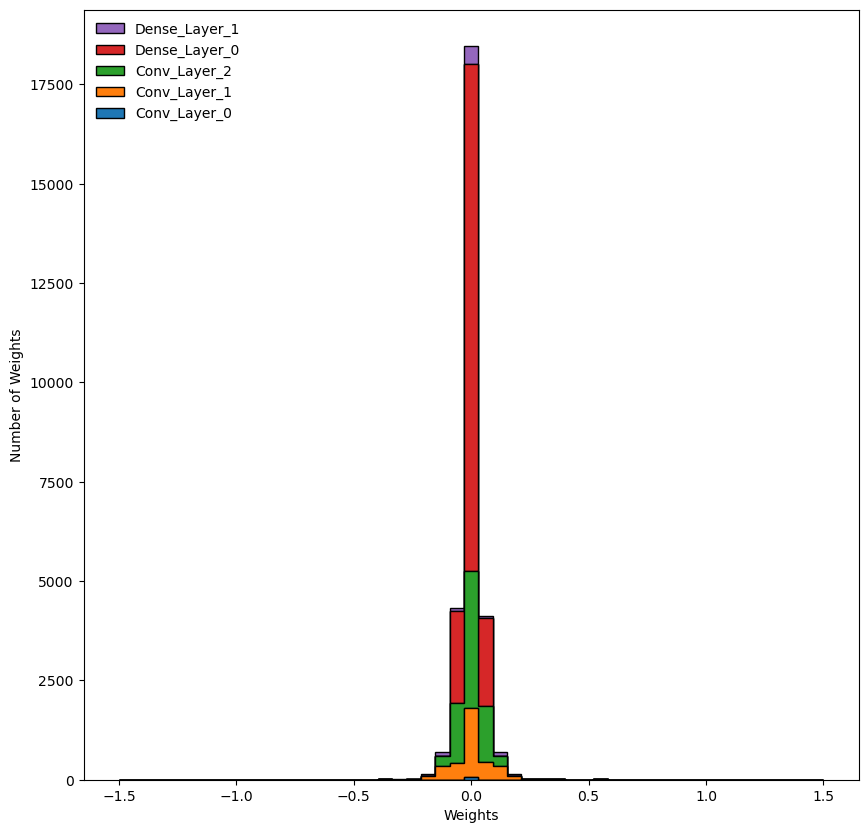

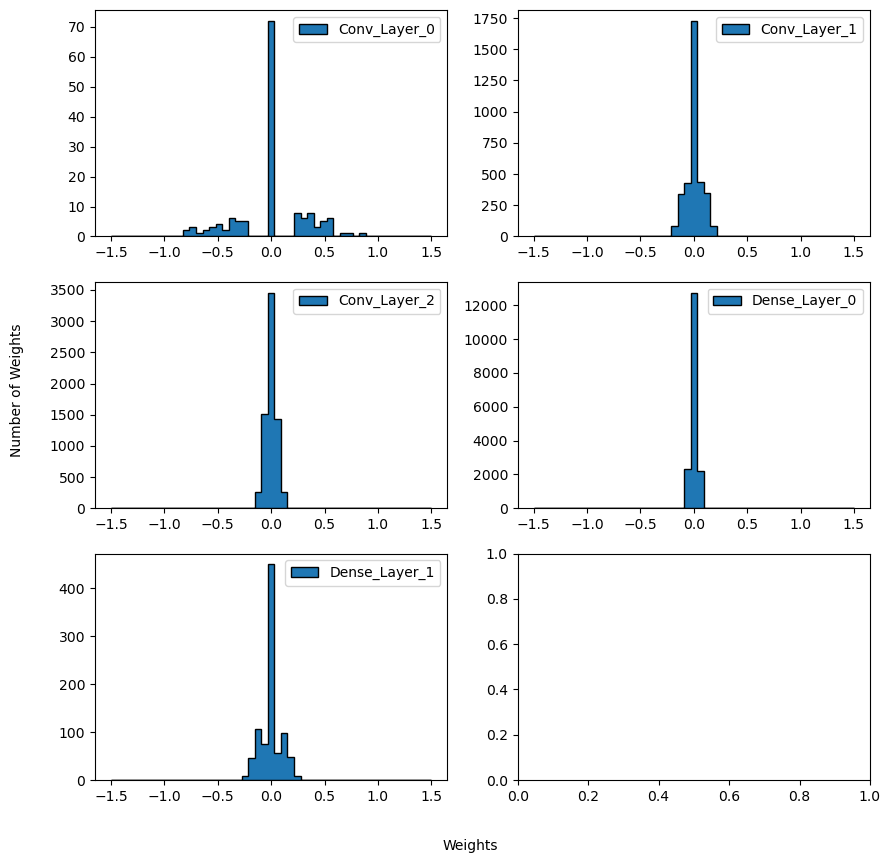

In [128]:
plot_weight_distribution(model_baseline_pruned)

# AUC

In [100]:
# Todo

# HLS4ML - Baseline

In [72]:
#Lets check if this model can be implemented completely unrolled (=parallel)
for layer in model_baseline_sequencial_pruned.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name,layersize)) # 0 = weights, 1 = biases
        if (layersize > 4096): # assuming that shape[0] is batch, i.e., 'None'
           print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name,layersize))


## Comentado

In [102]:
# import hls4ml
# from hls4ml.converters import convert_from_keras_model
# import plotting

# granularity='name'


# '''hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
# hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
# hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
# '''



# if granularity=='name':

#     config = hls4ml.utils.config_from_keras_model(model_baseline_pruned, granularity='name') 

#     # Set the precision and reuse factor for the full model
#     config['Model']['Precision'] = 'ap_fixed<24,18>'
#     config['Model']['ReuseFactor'] = 64
#     config['Model']['Strategy'] = 'Resource'

#     precision='ap_fixed<24,18>'
#     precision_conv_w=['ap_fixed<8,2>','ap_fixed<8,0>','ap_fixed<8,0>','ap_fixed<8,0>']
#     precision_dense_w=['ap_fixed<8,0>','ap_fixed<8,2>']
#     precision_conv_r=['ap_fixed<24,18>','ap_fixed<24,18>','ap_fixed<24,18>','ap_fixed<24,18>']

#     precision_bn_conv_scale=['ap_fixed<10,0>','ap_fixed<8,2>','ap_fixed<8,2>','ap_fixed<8,2>']
#     precision_bn_conv_bias=['ap_fixed<10,0>','ap_fixed<10,2>','ap_fixed<10,2>','ap_fixed<8,2>']

#     precision_bn_dense_scale=['ap_fixed<10,6>','ap_fixed<24,6>']
#     precision_bn_dense_bias=['ap_fixed<10,6>','ap_fixed<24,6>']

#     config['LayerName']['output_softmax']['Strategy'] ='Stable'
#     config['LayerName']['Input_layer']['Precision']      = 'ap_fixed<16,16>'
    
#     #precision_bias='ap_fixed<10,2>'
    
#     reuse_conv=[64,64,64,64]
#     reuse_dense=[64,64]
#     reuse_factor = 64
    
#     for i in range(3):
#         config['LayerName']['Conv_Layer_'+str(i)]['Precision']['weight'] = precision_conv_w[i]
#         #config['LayerName']['Conv_'+str(i)]['Precision']['bias']   = precision_bias
#         config['LayerName']['Conv_Layer_'+str(i)]['Precision']['result'] = precision_conv_r[i]
#         config['LayerName']['Conv_Layer_'+str(i)+'_linear']['Precision']    = precision
#         config['LayerName']['Conv_Layer_'+str(i)+'_linear']['table_t']      = precision
#         config['LayerName']['BN_conv'+str(i)]['Precision']['scale']= precision_bn_conv_scale[i]
#         config['LayerName']['BN_conv'+str(i)]['Precision']['bias'] = precision_bn_conv_bias[i]
#         config['LayerName']['act_Cov_'+str(i)]['Precision']        = precision
#         config['LayerName']['act_Cov_'+str(i)]['table_t']          = precision
#         config['LayerName']['AvgPool2D_'+str(i)]['Precision']      = precision

#         config['LayerName']['Conv_Layer_'+str(i)]['ReuseFactor']=            reuse_conv[i]
#         config['LayerName']['Conv_Layer_'+str(i)+'_linear']['ReuseFactor']=  reuse_conv[i]
#         config['LayerName']['Conv_Layer_'+str(i)+'_linear']['ReuseFactor']=  reuse_conv[i]
#         config['LayerName']['BN_conv'+str(i)]['ReuseFactor']=          reuse_conv[i]
#         config['LayerName']['BN_conv'+str(i)]['ReuseFactor']=          reuse_conv[i]
#         config['LayerName']['act_Cov_'+str(i)]['ReuseFactor']=         reuse_conv[i]
#         config['LayerName']['act_Cov_'+str(i)]['ReuseFactor']=         reuse_conv[i]
#         config['LayerName']['AvgPool2D_'+str(i)]['ReuseFactor']=       reuse_conv[i]



#     for i in range(2):
#         config['LayerName']['Dense_Layer_'+str(i)]['ReuseFactor']=           reuse_dense[i]
#         config['LayerName']['Dense_Layer_'+str(i)+'_linear']['ReuseFactor']= reuse_dense[i]
#         config['LayerName']['Dense_Layer_'+str(i)+'_linear']['ReuseFactor']= reuse_dense[i]
#         config['LayerName']['BN_dense'+str(i)]['ReuseFactor']=         reuse_dense[i]
#         config['LayerName']['BN_dense'+str(i)]['ReuseFactor']=         reuse_dense[i]
#         config['LayerName']['ACT_Dense_'+str(i)]['ReuseFactor']=       reuse_dense[i]
#         config['LayerName']['ACT_Dense_'+str(i)]['ReuseFactor']=       reuse_dense[i]

#         config['LayerName']['Dense_Layer_'+str(i)]['Precision']['weight'] = precision_dense_w[i]
#         config['LayerName']['Dense_Layer_'+str(i)]['Precision']['bias']   = precision
#         config['LayerName']['Dense_Layer_'+str(i)]['Precision']['result'] = 'ap_fixed<16,4>'
#         config['LayerName']['Dense_Layer_'+str(i)+'_linear']['Precision'] = precision
#         config['LayerName']['Dense_Layer_'+str(i)+'_linear']['table_t']   = precision
#         config['LayerName']['BN_dense'+str(i)]['Precision']         = precision_bn_dense_scale[i]
#         config['LayerName']['BN_dense'+str(i)]['bias']              = precision_bn_dense_bias[i]
#         config['LayerName']['ACT_Dense_'+str(i)]['Precision']       = precision
#         config['LayerName']['ACT_Dense_'+str(i)]['table_t']         = precision

#     config['LayerName']['output_dense']['Precision']['weight']  =precision
#     config['LayerName']['output_dense']['Precision']['bias']    =precision
#     config['LayerName']['output_dense']['Precision']['result']  =precision
#     config['LayerName']['output_dense_linear']['Precision']     =precision
#     config['LayerName']['output_dense_linear']['table_t']       =precision
#     config['LayerName']['output_softmax']['Precision']          ='ap_fixed<24,4,AP_RND,AP_SAT>'
#     config['LayerName']['output_softmax']['exp_table_t']        ='ap_fixed<24,4,AP_RND,AP_SAT>'
#     config['LayerName']['output_softmax']['inv_table_t']        ='ap_fixed<24,4,AP_RND,AP_SAT>'

#     config['LayerName']['output_dense']['ReuseFactor']=         reuse_factor
#     config['LayerName']['output_dense']['ReuseFactor']=         reuse_factor
#     config['LayerName']['output_dense']['ReuseFactor']=         reuse_factor
#     config['LayerName']['output_dense_linear']['ReuseFactor'] = reuse_factor
#     config['LayerName']['output_dense_linear']['ReuseFactor'] = reuse_factor
#     config['LayerName']['output_softmax']['ReuseFactor'] =      reuse_factor
#     config['LayerName']['output_softmax']['ReuseFactor'] =      reuse_factor
#     config['LayerName']['output_softmax']['ReuseFactor'] =      reuse_factor

# else:
#     config = hls4ml.utils.config_from_keras_model(model_baseline_pruned, granularity='model') 
#     config['Model']['Precision']='ap_fixed<32,16>'
#     config['Model']['ReuseFactor']=100
#     config['Model']['Strategy']='Resource'

# #cfg = hls4ml.converters.create_vivado_config()
# cfg = hls4ml.converters.create_config()
# cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
# cfg['HLSConfig']  = config
# cfg['KerasModel'] = model_baseline_pruned
# cfg['OutputDir']  = 'cnn_pruned/'
# cfg['XilinxPart'] = 'xczu7ev-ffvc1156-2-e'
# cfg['Backend']='Vivado'

# hls_model = hls4ml.converters.keras_to_hls(cfg)
# hls_model.compile()

In [103]:
# hls4ml.model.profiling.numerical(model=model_baseline_pruned, hls_model=hls_model

In [104]:
# hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [105]:
# samples=100 #number of samples to test the model
# x_train_reduced=x_train[:samples]

# x_train_reduced=x_train_reduced.astype('float32') #Invalid type (int16)
# x_train_reduced=np.ascontiguousarray(x_train_reduced)

# y_pruned=model_baseline_pruned.predict(x_train_reduced)
# y_pruned= np.argmax(y_pruned, axis=1)
# n_correct=np.sum(np.equal(y_pruned,y_train[:samples])) #n_correct is the number of correct predictions
# print('Model Prunned')
# print(n_correct)
# print('Accuracy: {}%'.format((n_correct/samples)*100))
# print('')


# print('HLS Model')
# y_hls=hls_model.predict(x_train_reduced)
# y_hls = np.argmax(y_hls, axis=1)
# n_correct=np.sum(np.equal(y_hls,y_train[:samples]))    #n_correct is the number of correct predictions
# print(n_correct)
# print('Accuracy: {}%'.format((n_correct/samples)*100))

In [106]:
#pip install --force-reinstall numpy==1.24.4 mdit-py-plugins==0.3.1 myst-parser==0.18.1 numba==0.57.0

## Aqui sim

In [192]:
print(hls4ml.__version__)

0.7.1


In [ ]:
'''
Selecionar amostras para André

y_testar=np.argmax(y_cat_test,axis=1)
y_cat_test[1451]
x_andre=x_test[[0,1280,1374,1451]]
y_andre=y_cat_test[[0,1280,1374,1451]]
y_andre

np.save('x_andre.npy',x_andre)
np.save('y_andre.npy',y_andre)
'''

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
myst-parser 0.18.1 requires mdit-py-plugins~=0.3.1, but you have mdit-py-plugins 0.4.0 which is incompatible.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 1.25.2 which is incompatible.

In [193]:
for layer in qmodel_sequencial.layers:
    print(layer.name)


q_conv2d_batchnorm_33
q_activation_44
max_pooling2d_33
q_conv2d_batchnorm_34
q_activation_45
max_pooling2d_34
q_conv2d_batchnorm_35
q_activation_46
max_pooling2d_35
flatten_12
q_dense_22
batch_normalization_63
q_activation_47
q_dense_23
batch_normalization_64
q_activation_48
dense_14
activation_12


In [69]:
import hls4ml
from hls4ml.converters import convert_from_keras_model
import plotting


# Then the QKeras model
'''hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
'''

reuse_model=256

q_hls_config = hls4ml.utils.config_from_keras_model(model_quantized_sequencial_pruned, granularity='name')
q_hls_config['Model']['ReuseFactor'] = reuse_model
q_hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
q_hls_config['Model']['Strategy'] = 'Stable'


#q_hls_config['LayerName']['activation_1']['Strategy'] = 'Resource'
q_hls_config['LayerName']['q_conv2d_batchnorm_input']['Precision']      = 'ap_fixed<16,16>'

#for layer in qmodel.layers:
#   if ('conv' in layer.name.upper()) or ('dense' in layer.name.upper()):
        #q_hls_config['LayerName'][layer.name]['ReuseFactor'] =    reuse_model
    #if 'POOL' in layer.name.upper():
    #    q_hls_config['LayerName'][layer.name]['Precision']='ap_fixed<32,16>'

        
#q_hls_config['LayerName']['output_dense']['ReuseFactor'] =        reuse_model
#q_hls_config['LayerName']['output_softmax']['ReuseFactor'] =      reuse_model
#q_hls_config['LayerName']['output_dense_linear']['ReuseFactor'] = reuse_model

#q_hls_config['LayerName']['output_dense_linear']['ReuseFactor'] = reuse_model

'''
q_cfg = hls4ml.converters.create_config(backend='Vivado')
q_cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
q_cfg['HLSConfig']  = q_hls_config
q_cfg['KerasModel'] = qmodel_pruned
q_cfg['OutputDir']  = 'q_cnn_pruned/hls4ml_model'
#q_cfg['XilinxPart'] = 'xczu7ev-ffvc1156-2-e'
'''
#q_hls_model= hls4ml.converters.keras_to_hls(q_cfg)
#q_hls_model.compile()

q_hls_model_test = convert_from_keras_model(
    model_quantized_sequencial_pruned,input_data_tb='data/x_andre.npy',output_data_tb='data/y_andre.npy' ,hls_config=q_hls_config, 
    part='xcu250-figd2104-2L-e', 
    output_dir= "model_quantized_pruned_Andre/", io_type= 'io_stream',
    backend= "Vivado"
)
print("----------------------------------------------------------------------------------")
q_hls_model_test.compile()
print("---------------------------")

Interpreting Sequential
Topology:
Layer name: q_conv2d_batchnorm_input, layer type: InputLayer, input shapes: [[None, 64, 32, 1]], output shape: [None, 64, 32, 1]
Layer name: q_conv2d_batchnorm, layer type: QConv2DBatchnorm, input shapes: [[None, 64, 32, 1]], output shape: [None, 62, 30, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 62, 30, 16]], output shape: [None, 31, 30, 16]
Layer name: q_conv2d_batchnorm_1, layer type: QConv2DBatchnorm, input shapes: [[None, 31, 30, 16]], output shape: [None, 29, 28, 32]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 29, 28, 32]], output shape: [None, 29, 28, 32]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 29, 28, 32]], output shape: [None, 14, 14, 32]
Layer name: q_conv2d_batchnorm_2, layer type: QConv2DBatchnorm, input shapes: [[None, 14, 14, 32]], output shape: [None, 12, 12, 64]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 12

Done
---------------------------


Interpreting Sequential
Topology:
Layer name: q_conv2d_batchnorm_input, layer type: InputLayer, input shapes: [[None, 64, 32, 1]], output shape: [None, 64, 32, 1]
Layer name: q_conv2d_batchnorm, layer type: QConv2DBatchnorm, input shapes: [[None, 64, 32, 1]], output shape: [None, 62, 30, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 62, 30, 16]], output shape: [None, 31, 30, 16]
Layer name: q_conv2d_batchnorm_1, layer type: QConv2DBatchnorm, input shapes: [[None, 31, 30, 16]], output shape: [None, 29, 28, 32]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 29, 28, 32]], output shape: [None, 29, 28, 32]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 29, 28, 32]], output shape: [None, 14, 14, 32]
Layer name: q_conv2d_batchnorm_2, layer type: QConv2DBatchnorm, input shapes: [[None, 14, 14, 32]], output shape: [None, 12, 12, 64]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 12

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

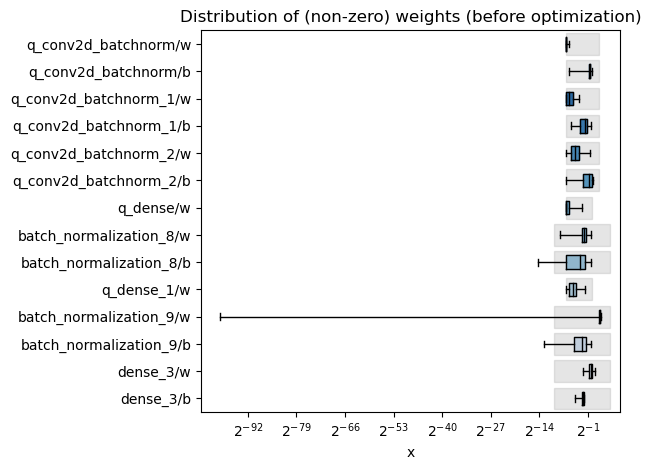

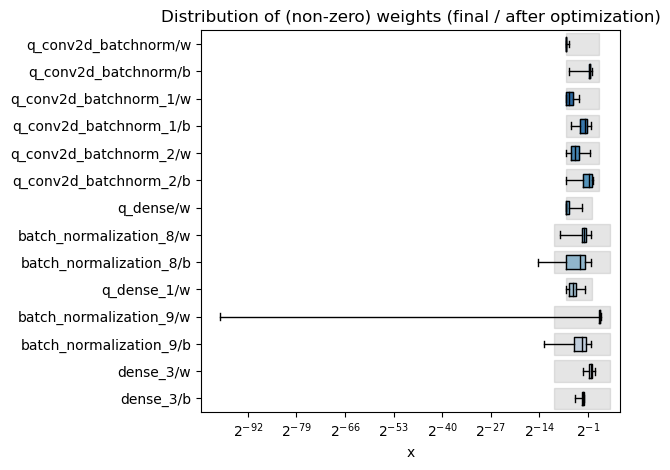

In [70]:
hls4ml.model.profiling.numerical(model=qmodel_sequencial, hls_model=q_hls_model_test)

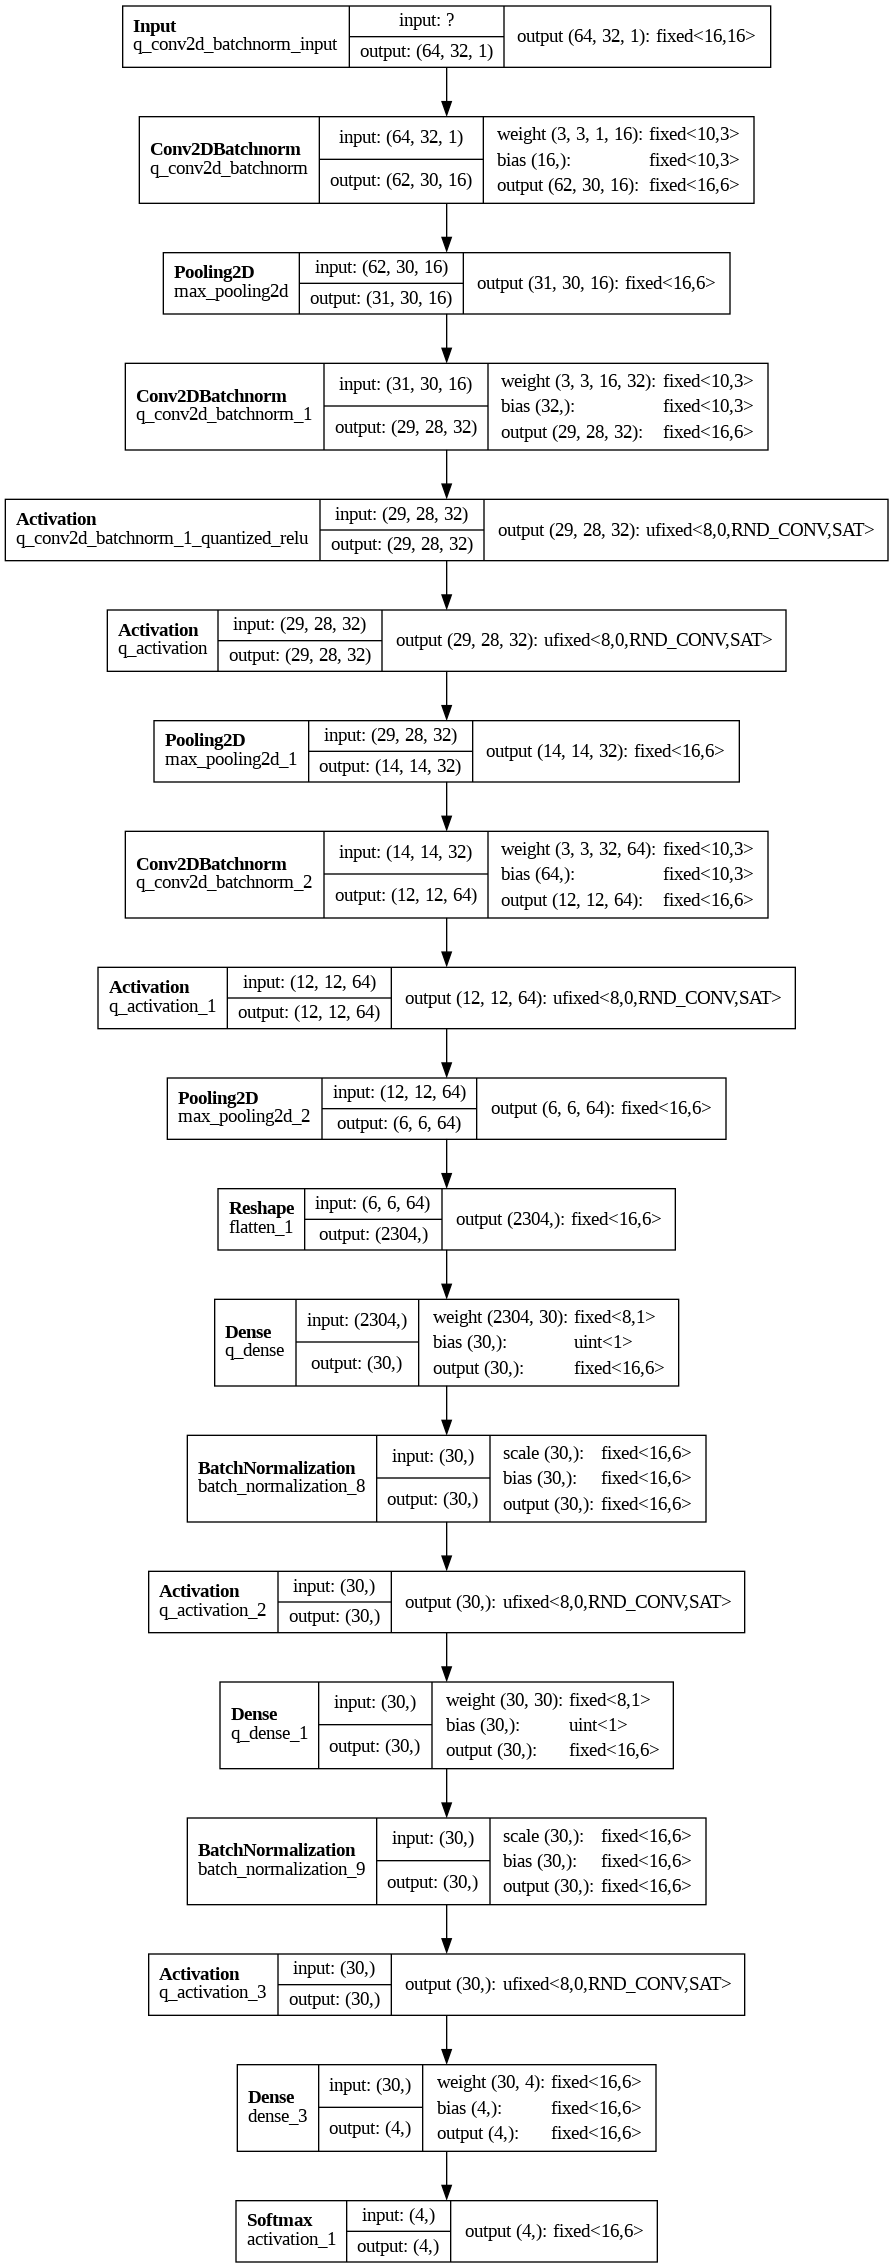

In [72]:
hls4ml.utils.plot_model(q_hls_model_test, show_shapes=True, show_precision=True, to_file=None)

In [73]:
samples=100 #number of samples to test the model
x_train_reduced=x_train[:samples]

x_train_reduced=x_train_reduced.astype('float32') #Invalid type (int16)
x_train_reduced=np.ascontiguousarray(x_train_reduced)

y_pruned=qmodel_sequencial.predict(x_train_reduced)
y_pruned= np.argmax(y_pruned, axis=1)
n_correct=np.sum(np.equal(y_pruned,y_train[:samples])) #n_correct is the number of correct predictions
print('Model Prunned')
print(n_correct)
print('Accuracy: {}%'.format((n_correct/samples)*100))
print('')


print('HLS Model')
y_hls=q_hls_model_test.predict(x_train_reduced)
y_hls = np.argmax(y_hls, axis=1)
n_correct=np.sum(np.equal(y_hls,y_train[:samples]))    #n_correct is the number of correct predictions
print(n_correct)
print('Accuracy: {}%'.format((n_correct/samples)*100))

4/4 [==============================] - 0s 19ms/step
Model Prunned
100
Accuracy: 100.0%

HLS Model
100
Accuracy: 100.0%


In [74]:
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
q_hls_model_test.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jovyan' on host '711b01861e5c' (Linux_x86_64 version 6.8.0-40-generic) on Mon Aug 19 12:08:41 UTC 2024
INFO: [HLS 200-10] In directory '/home/jovyan/work/model_quantized_pruned_Andre'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/jovyan/work/model_quantized_pruned_Andre/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [HLS 20

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.366',
  'BestLatency': '442021',
  'WorstLatency': '443050',
  'IntervalMin': '172981',
  'IntervalMax': '442681',
  'BRAM_18K': '456',
  'DSP': '354',
  'FF': '167542',
  'LUT': '217151',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'},
 'VivadoSynthReport': {'LUT': '110900',
  'FF': '150793',
  'BRAM_18K': '160',
  'URAM': '0',
  'DSP48E': '402'}}

In [ ]:
hls4ml.model.profiling.numerical(model=qmodel_pruned, hls_model=q_hls_model)

In [ ]:
samples=100 #number of samples to test the model
x_train_reduced=x_train[:samples]

x_train_reduced=x_train_reduced.astype('float32') #Invalid type (int16)
x_train_reduced=np.ascontiguousarray(x_train_reduced)

qy_pruned=qmodel_pruned.predict(x_train_reduced)
qy_pruned= np.argmax(qy_pruned, axis=1)
n_correct=np.sum(np.equal(qy_pruned,y_train[:samples])) #n_correct is the number of correct predictions
print('Model Quantized Pruned')
print(n_correct)
print('Accuracy: {}%'.format((n_correct/samples)*100))
print('')


print('HLS Quantized Model')
qy_hls=q_hls_model.predict(x_train_reduced)
qy_hls = np.argmax(qy_hls, axis=1)
n_correct=np.sum(np.equal(qy_hls,y_train[:samples]))    #n_correct is the number of correct predictions
print(n_correct)
print('Accuracy: {}%'.format((n_correct/samples)*100))


In [ ]:
hls4ml.utils.plot_model(q_hls_model, show_shapes=True, show_precision=True, to_file=None)

In [ ]:
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
q_hls_model.build(csim=True, synth=True, vsynth=True)

In [ ]:
1/0

Now, we need to define the hls4ml and Vivado configurations. Two things will change with respect to what was done in the previous exercises. First, we will use ``IOType= 'io_stream'`` in the Vivado configuration.

---
****You must use ``IOType= 'io_stream'`` if attempting to synthesize a large convolutional neural network.****

---
The CNN implementation in hls4ml is based on streams, which are synthesized in hardware as first in, first out (FIFO) buffers. Shift registers are used to keep track of the last  ``<kernel height - 1>`` rows of input pixels, and maintains a shifting snapshot of the convolution kernel.

This is illustrated  in the gif below. Here, the input image is at the top-left and the output image at the bottom left. The top right image shows the internal state of the shift registers and convolutional kernel. The red square indicates the current pixels contained within the convolutional kernel.

![alt text](images/conv2d_animation.gif "The implementation of convolutional layers in hls4ml.")

Lastly, we will use ``['Strategy'] = 'Latency'`` for all the layers in the hls4ml configuration. If one layer would have >4096 elements, we sould set ``['Strategy'] = 'Resource'`` for that layer, or increase the reuse factor by hand. You can find examples of how to do this below.

## Bonus exercise: Automatic quantization with AutoQKeras

In this bonus exercise, you will learn how to find the optimal heterogeneously quantized model using AutoQKeras.
For more details, you can look at the [AutoQKeras notebook](https://github.com/google/qkeras/blob/master/notebook/AutoQKeras.ipynb). 

Let's first check the estimated energy consumption of the QKeras 6-bit model using QTools. By setting ```for_reference=True``` you can print out the unquantized model energy consumption and compare the two. Note that this only works for QKeras layers. 

In [ ]:
filters_per_conv_layer = [16, 16, 24]
neurons_per_dense_layer = [42, 64]

x = x_in = Input(input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding convolutional block {} with N={} filters').format(i, f))
    x = Conv2D(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=False,
        name='conv_{}'.format(i),
    )(x)
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding dense block {} with N={} neurons').format(i, n))
    x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = Activation('relu', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)

baseline_model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

LOSS = tf.keras.losses.CategoricalCrossentropy()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

baseline_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

In [ ]:
from qkeras import print_qstats

# for automatic quantization
import pprint
from qkeras.autoqkeras import *
from qkeras import *
from qkeras.utils import model_quantize

from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from qkeras import quantized_bits
from qkeras import QDense, QActivation

q = run_qtools.QTools(
    baseline_model,
    process="horowitz",
    source_quantizers=[quantized_bits(16, 5, 1)],
    is_inference=True,
    weights_path=None,
    keras_quantizer="fp16",
    keras_accumulator="fp16",
    for_reference=False,
)
q.qtools_stats_print()

energy_dict = q.pe(
    weights_on_memory="fixed", activations_on_memory="fixed", min_sram_size=8 * 16 * 1024 * 1024, rd_wr_on_io=False
)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()

print("Total energy: {:.6f} uJ".format(total_energy / 1000000.0))

Now, lets use AutoQKeras to find an optimally heterogeneously quantized model for us. For more details, check the AutoQKeras tutorial linked above. As baseline model, we'll use the pruned floating point Keras model from above.

In [ ]:
# These are the quantizers we'll test in the bayesian optimization
quantization_config = {
    "kernel": {
        "quantized_bits(2,0,1,alpha=1.0)": 2,
        "quantized_bits(4,0,1,alpha=1.0)": 4,
        "quantized_bits(6,0,1,alpha=1.0)": 6,
        "quantized_bits(8,0,1,alpha=1.0)": 8,
    },
    "bias": {
        "quantized_bits(2,0,1,alpha=1.0)": 2,
        "quantized_bits(4,0,1,alpha=1.0)": 4,
        "quantized_bits(6,0,1,alpha=1.0)": 6,
        "quantized_bits(8,0,1,alpha=1.0)": 8,
    },
    "activation": {
        "quantized_relu(3,1)": 3,
        "quantized_relu(4,2)": 4,
        "quantized_relu(8,2)": 8,
        "quantized_relu(8,4)": 8,
        "quantized_relu(16,6)": 16,
    },
    "linear": {
        "quantized_bits(2,0,1,alpha=1.0)": 2,
        "quantized_bits(4,0,1,alpha=1.0)": 4,
        "quantized_bits(6,0,1,alpha=1.0)": 6,
        "quantized_bits(8,0,1,alpha=1.0)": 8,
    },
}

# These are the layer types we will quantize
limit = {
    "Dense": [8, 8, 16],
    "Conv2D": [8, 8, 16],
    "Activation": [16],
}

# Use this if you want to minimize the model bit size
goal_bits = {
    "type": "bits",
    "params": {
        "delta_p": 8.0,  # We tolerate up to a +8% accuracy change
        "delta_n": 8.0,  # We tolerate down to a -8% accuracy change
        "rate": 2.0,  # We want a x2 times smaller model
        "stress": 1.0,  # Force the reference model size to be smaller by setting stress<1
        "input_bits": 8,
        "output_bits": 8,
        "ref_bits": 8,
        "config": {"default": ["parameters", "activations"]},
    },
}

# Use this if you want to minimize the model energy consumption
goal_energy = {
    "type": "energy",
    "params": {
        "delta_p": 8.0,
        "delta_n": 8.0,
        "rate": 2.0,
        "stress": 1.0,
        "process": "horowitz",
        "parameters_on_memory": ["sram", "sram"],
        "activations_on_memory": ["sram", "sram"],
        "rd_wr_on_io": [False, False],
        "min_sram_size": [0, 0],
        "source_quantizers": ["fp32"],
        "reference_internal": "int8",
        "reference_accumulator": "int32",
    },
}

run_config = {
    "goal": goal_energy,
    "quantization_config": quantization_config,
    "learning_rate_optimizer": False,
    "transfer_weights": False,  # Randomely initialize weights
    "mode": "bayesian",  # This can be bayesian,random,hyperband
    "seed": 42,
    "limit": limit,
    "tune_filters": "layer",
    "tune_filters_exceptions": "^output",
    "distribution_strategy": None,
    "max_trials": 5,  # Let's just do 5 trials for this demonstrator, ideally you should do as many as possible
}

In [ ]:
from qkeras.autoqkeras import AutoQKeras

autoqk = AutoQKeras(baseline_model, output_dir="autoq_cnn", metrics=["acc"], custom_objects={}, **run_config)
autoqk.fit(train_data, validation_data=val_data, epochs=15)

aqmodel = autoqk.get_best_model()
print_qmodel_summary(aqmodel)

# Train for the full epochs
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
]

start = time.time()
history = aqmodel.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
end = time.time()
print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

In [ ]:
# This model has some remnants from the optimization procedure attached to it, so let's define a new one
aqmodel.save_weights("autoqkeras_cnn_weights.h5")

layers = [l for l in aqmodel.layers]
x = layers[0].output
for i in range(1, len(layers)):
    x = layers[i](x)

new_model = Model(inputs=[layers[0].input], outputs=[x])
LOSS = tf.keras.losses.CategoricalCrossentropy()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

new_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])
new_model.summary()
new_model.load_weights("autoqkeras_cnn_weights.h5")
print_qmodel_summary(new_model)

Let's check what the best heterogeneously quantized model looks like (keep in mind we only did a few trials, the optimization obviosuly didn't have time to converge at the minimum but yo get the idea!)

In [ ]:
hls_config_aq = hls4ml.utils.config_from_keras_model(new_model, granularity='name')
hls_config_aq['Model']['ReuseFactor'] = 1
hls_config_aq['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_aq['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config_aq)

cfg_aq = hls4ml.converters.create_config(backend='Vivado')
cfg_aq['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg_aq['HLSConfig'] = hls_config_aq
cfg_aq['KerasModel'] = new_model
cfg_aq['OutputDir'] = 'autoqkeras_cnn/'
cfg_aq['XilinxPart'] = 'xcu250-figd2104-2L-e'

hls_model_aq = hls4ml.converters.keras_to_hls(cfg_aq)
hls_model_aq.compile()

In [ ]:
y_predict_aq = aqmodel.predict(X_test_reduced)
y_predict_hls4ml_aq = hls_model_aq.predict(np.ascontiguousarray(X_test_reduced))


accuracy_keras = float(accuracy_score(np.argmax(Y_test_reduced, axis=1), np.argmax(y_predict_aq, axis=1)))
accuracy_hls4ml = float(accuracy_score(np.argmax(Y_test_reduced, axis=1), np.argmax(y_predict_hls4ml_aq, axis=1)))

print("Accuracy AutoQ Keras:  {}".format(accuracy_keras))
print("Accuracy AutoQ hls4ml: {}".format(accuracy_hls4ml))

The accuracy is slightly lower for this heterogeneously quantized model. Due to some randomness in the optimization procedure, you're going to have to synthesize this one yourself!

In [ ]:
synth = True
if synth:
    hls_model_aq.build(csim=False, synth=True, vsynth=True)
    data_autoq = getReports('autoq_cnn')

    print("\n Resource usage and latency: AutoQ")
    pprint.pprint(data_autoq)